In [1]:
import os
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots

import psycopg2
import sqlalchemy
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
from dotenv import load_dotenv

import seaborn as sns

# Import credientials - returns true if successful
load_dotenv('./secrets.env', )
backboard_user = os.getenv('BACKBOARD_USER')
backboard_pass = os.getenv('BACKBOARD_PASS')
backboard_host = os.getenv('BACKBOARD_HOST')
backboard_port = os.getenv('BACKBOARD_PORT')
backboard_dbname = os.getenv('BACKBOARD_DBNAME')

url_object = URL.create(
    "postgresql",
    username=backboard_user,
    password=backboard_pass,  
    host=backboard_host,
    port=backboard_port,
    database=backboard_dbname
)
engine = sqlalchemy.create_engine(url_object)
con=engine.connect()

# A wrapper for executing the SQL query
def run_query(query_str: str):
    con=engine.connect()
    df = pd.read_sql_query(sql=text(query_str), con=con)
    con.close()
    return df

True

In [113]:
player_id = 83362
query = f"""

SELECT *
FROM
(SELECT tournament_id, player_id, ratings_value, position, 
       ROW_NUMBER () OVER (PARTITION BY tournament_id ORDER BY ratings_value DESC) as pred_position
FROM
    (SELECT tournament_id, player_id, position, COALESCE(ratings_value, 0) AS ratings_value
    FROM
        -- Get all results from all those tournaments
        (SELECT player_id, tournament_id, position, ratings_value
        FROM player_results
        WHERE tournament_id IN
            -- Get all of the tournament_id's for a player
            (SELECT tournament_id
            FROM player_results
            WHERE player_id = {player_id}::text)) AS y) as x) as z
WHERE player_id = {player_id}::text    

"""
df = run_query(query)
df

,tournament_id,player_id,ratings_value,position,pred_position
0,42659,83362,0.0,17,24


In [77]:
# WORKS!

player_id = 83361
query = f"""

SELECT *, pred_position - position AS resid_position
FROM
(SELECT tournament_id, tournament_name, date, player_id, position, ratings_value,
       ROW_NUMBER () OVER (PARTITION BY tournament_id ORDER BY ratings_value DESC) as pred_position
    FROM
    (SELECT player_id, tournament_id, tournament_name, date, position, coalesce(ratings_value, '0') as ratings_value
        FROM
            -- Get all results from all those tournaments
            (SELECT player_id, tournament_id, tournament_name, position, ratings_value, date
            FROM player_results
            WHERE tournament_id IN
                -- Get all of the tournament_id's for a player
                (SELECT tournament_id
                FROM player_results
                WHERE player_id = {player_id}::text)) AS y) AS z) AS x
WHERE player_id = {player_id}::text
ORDER BY tournament_id, position
"""
df = run_query(query)
#df.to_csv('pred_pos.csv')
df

,tournament_id,tournament_name,date,player_id,position,ratings_value,pred_position,resid_position
0,42659,No Quarter: Mandalorian Launch Party,2021-08-25,83361,21,0.00,23,2
1,42660,No Quarter: Weekly Strikes,2021-09-01,83361,17,1016.56,18,1
2,43911,No Quarter: Weekly Strikes,2021-09-22,83361,21,1001.02,23,2
3,43914,No Quarter: Weekly Strikes,2021-10-13,83361,20,994.87,18,-2
4,46277,No Quarter: Weekly Strikes,2022-01-19,83361,18,987.25,19,1
5,46278,No Quarter: Weekly Strikes,2022-01-12,83361,22,976.04,24,2
6,46280,No Quarter: Weekly Strikes,2022-02-16,83361,32,1055.96,32,0
7,46283,No Quarter: Weekly Strikes,2022-02-02,83361,24,1057.02,23,-1
8,46284,No Quarter: Weekly Strikes,2022-02-09,83361,22,1020.67,30,8
9,46285,No Quarter: Weekly Strikes,2022-01-26,83361,23,995.89,29,6


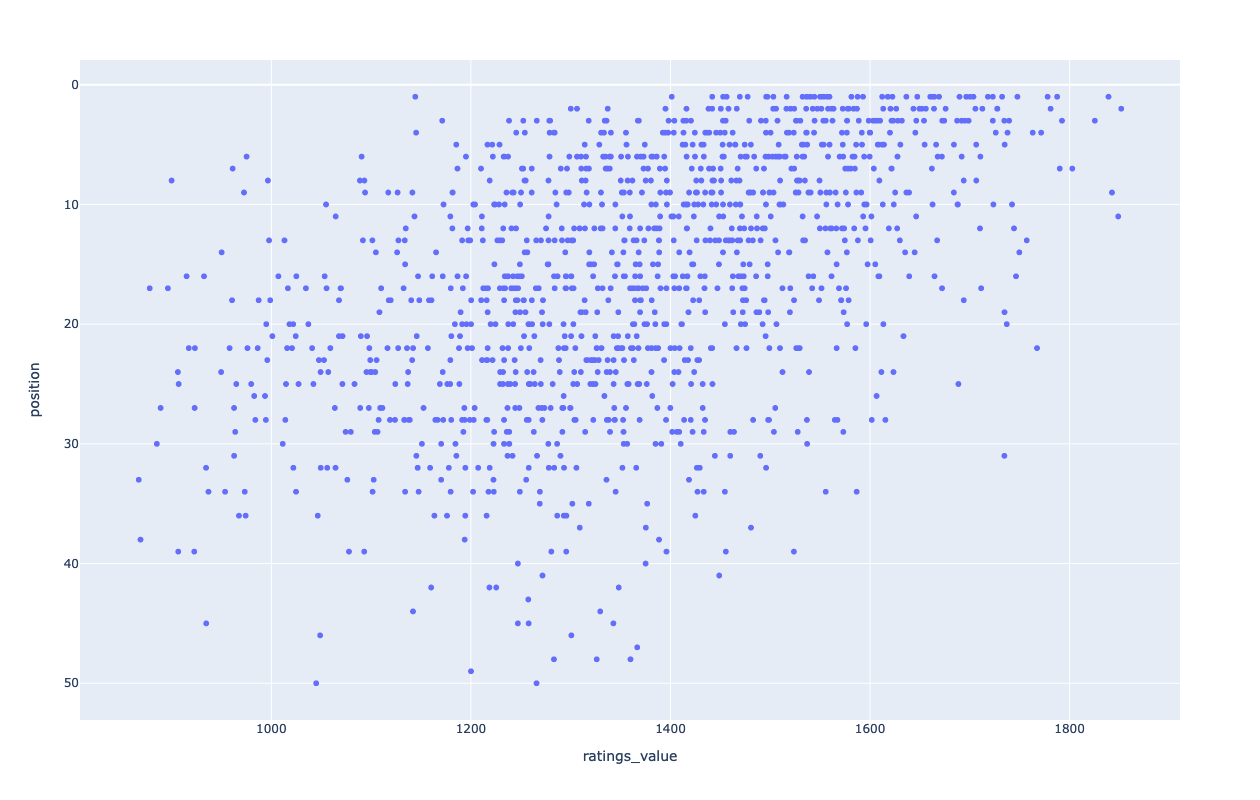

In [65]:
#fig = px.line(df, x='date', y='ratings_value', title='IFPA Rating')
fig = px.line(df.query("ratings_value > 0"), x="ratings_value", y="position", width=800, height=800)
fig.update_yaxes(autorange="reversed")
#fig.show()

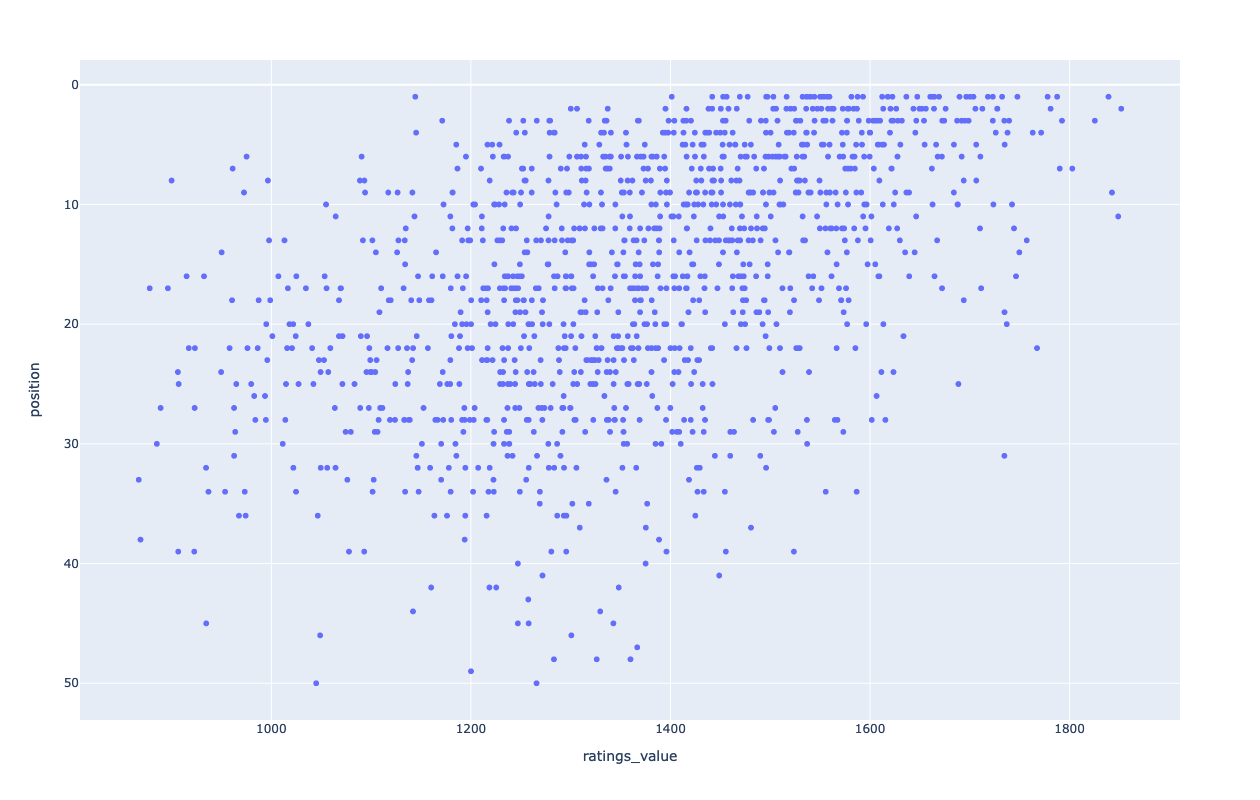

In [65]:
#fig = px.line(df, x='date', y='ratings_value', title='IFPA Rating')
fig = px.scatter(df.query("ratings_value > 0"), x="ratings_value", y="position", width=800, height=800)
fig.update_yaxes(autorange="reversed")
#fig.show()

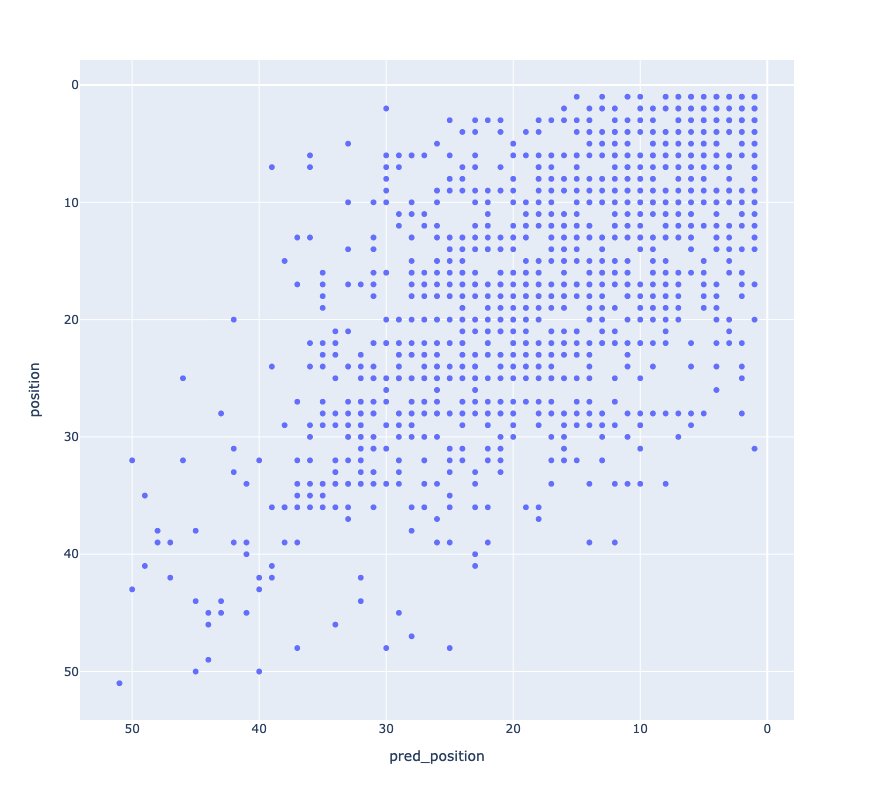

In [55]:
#fig = px.line(df, x='date', y='ratings_value', title='IFPA Rating')
fig = px.scatter(df, x="pred_position", y="position", width=800, height=800)
fig.update_xaxes(autorange="reversed")
fig.update_yaxes(autorange="reversed")

fig.show();

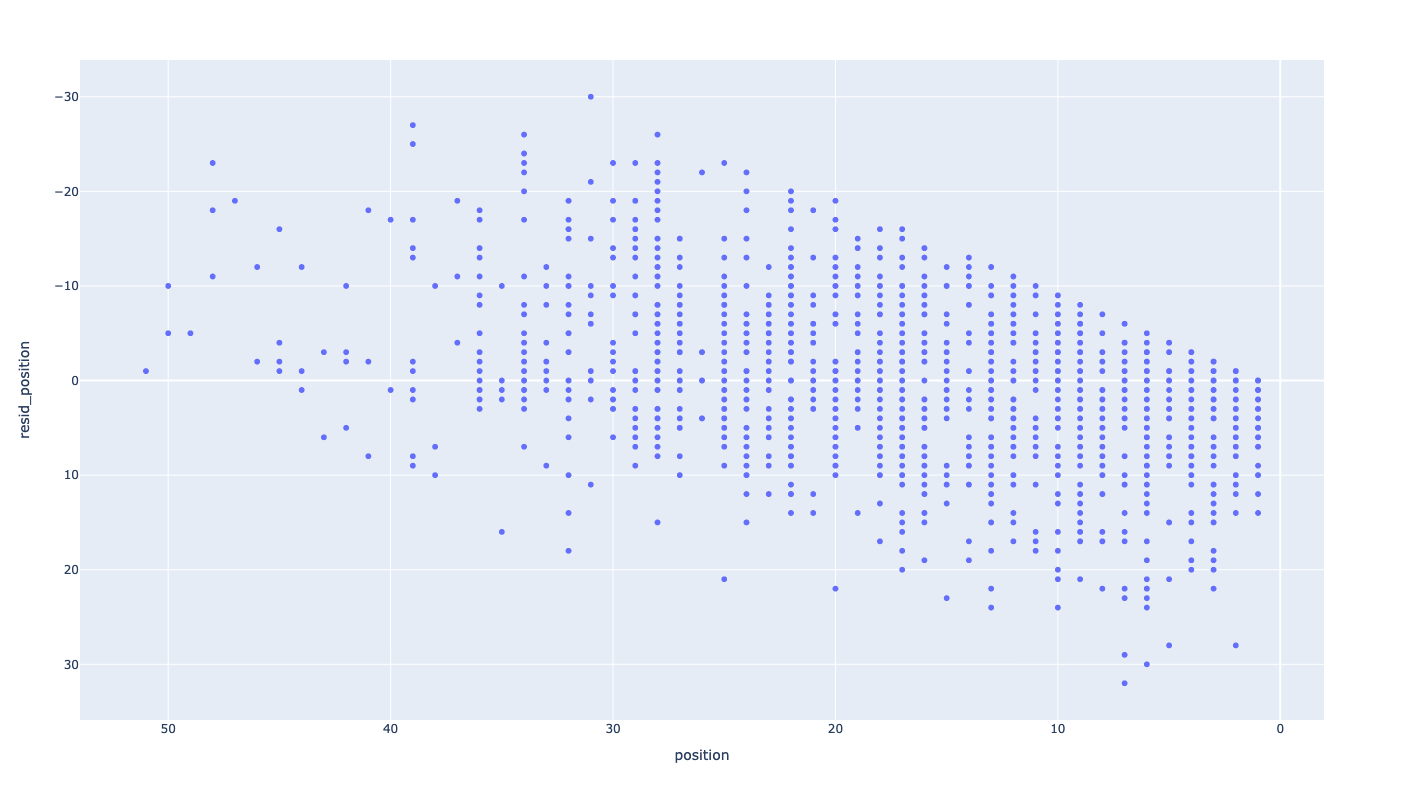

In [68]:
fig = px.scatter(df, x="position", y="resid_position", width=800, height=800)
fig.update_xaxes(autorange="reversed")
fig.update_yaxes(autorange="reversed")

fig.show();

In [30]:
df.to_csv('pos_deltas.csv')

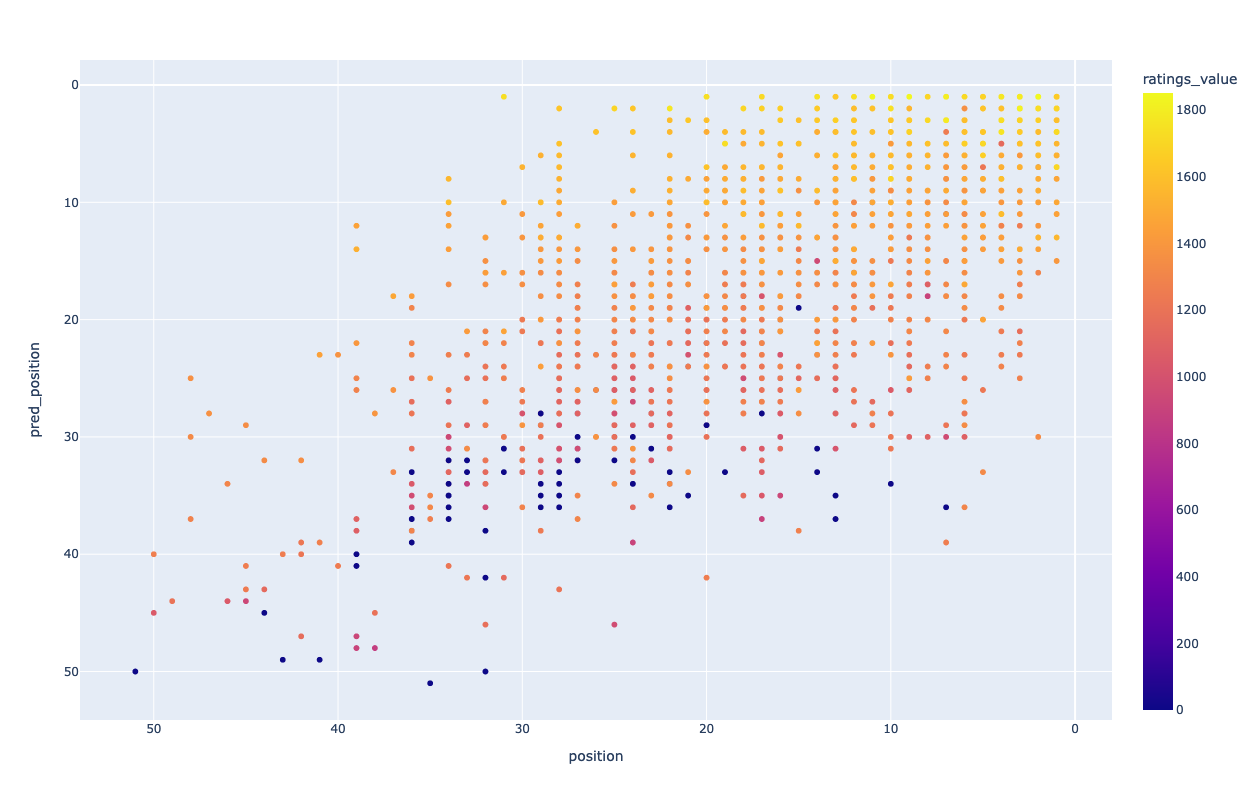

In [66]:
#fig = px.line(df, x='date', y='ratings_value', title='IFPA Rating')
df['pos_delta'] = df['pred_position'] - df['position']
fig = px.scatter(df, x="position", y="pred_position", color = 'ratings_value', width=800, height=800)
fig.update_xaxes(autorange="reversed")
fig.update_yaxes(autorange="reversed")

fig.show();

,tournament_id,player_id,position,ratings_value,pred_position,pos_delta
0,42659,66720,1,1581.29,7,6
1,42659,33701,2,1523.99,8,6
2,42659,62187,3,1610.05,5,2
3,42659,67414,4,1445.67,10,6
4,42659,80155,5,1412.15,12,7


<Axes: xlabel='position', ylabel='pos_delta'>

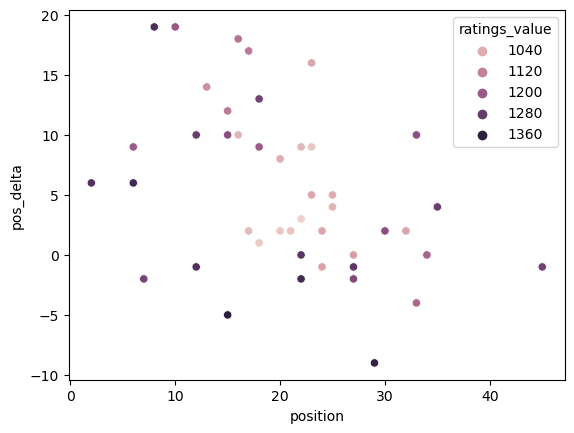

In [ ]:
df['pos_delta'] = df['pred_position'] - df['position']
df.head()
sns.scatterplot(data = df.query("player_id == '83361'"), x = 'position', y = 'pos_delta', hue = 'ratings_value')